d:\Anaconda\envs\ts\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


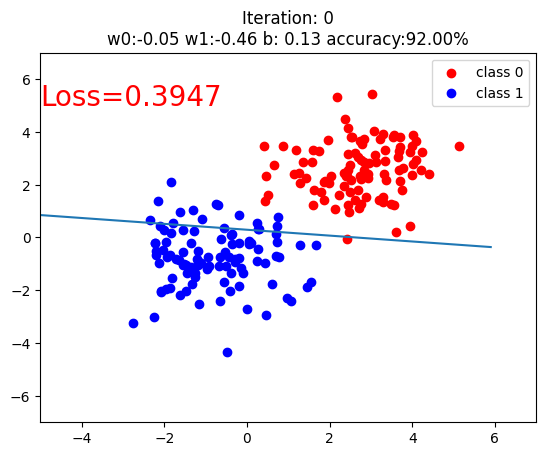

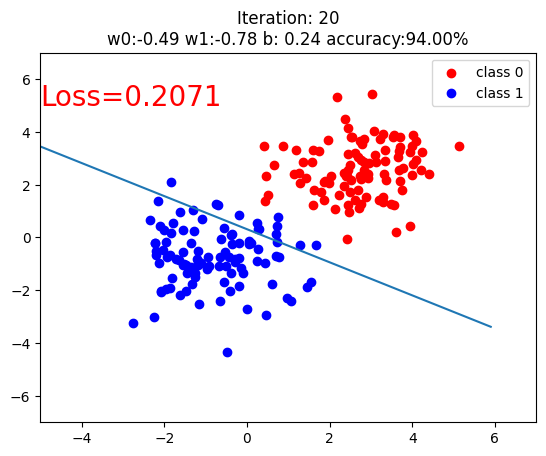

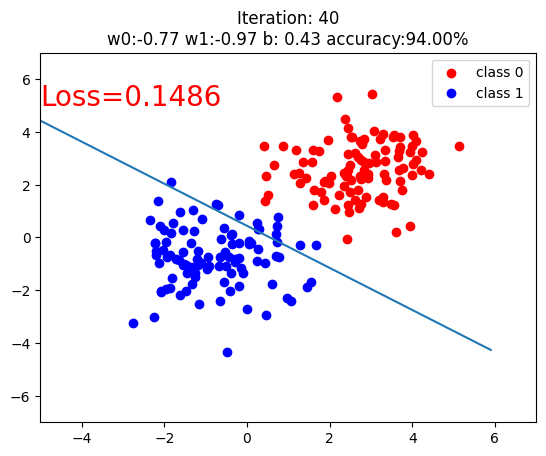

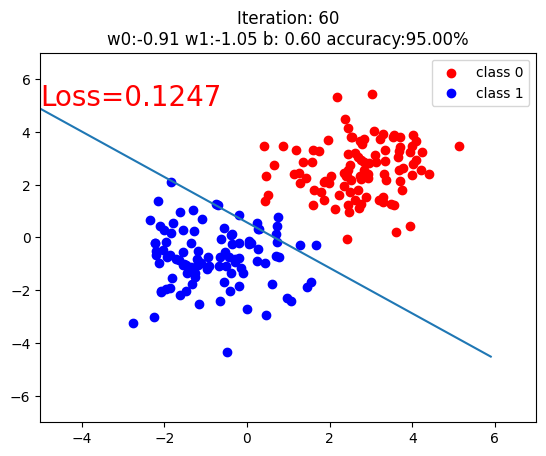

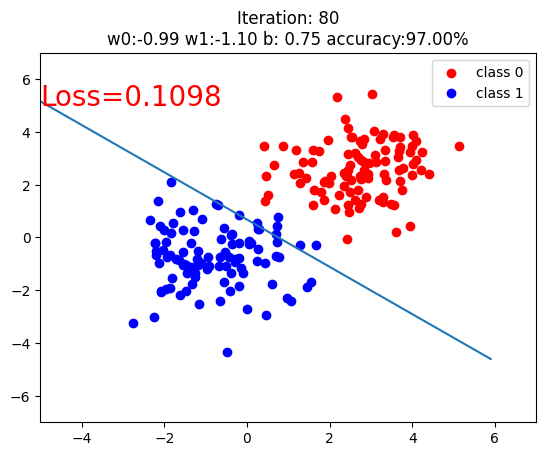

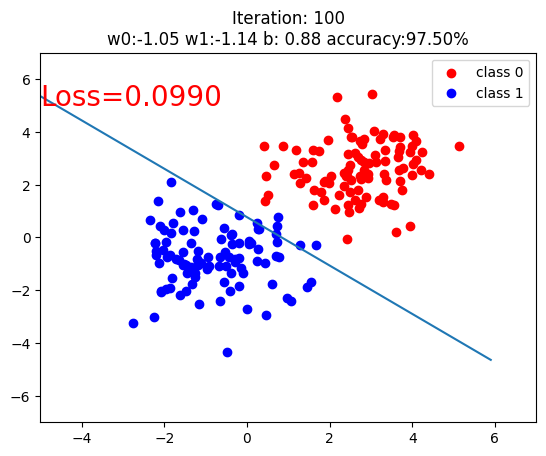

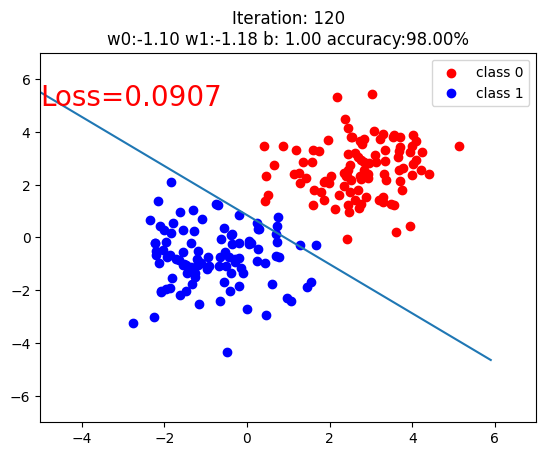

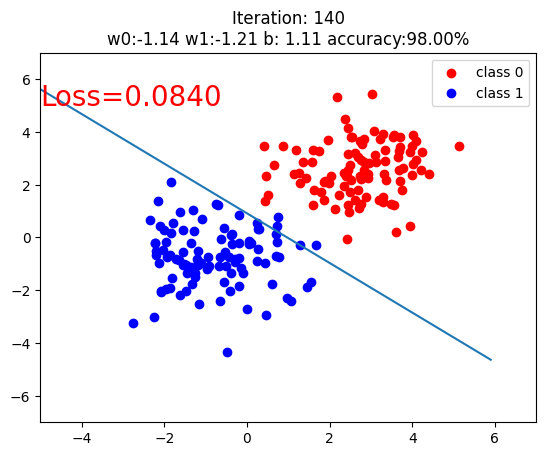

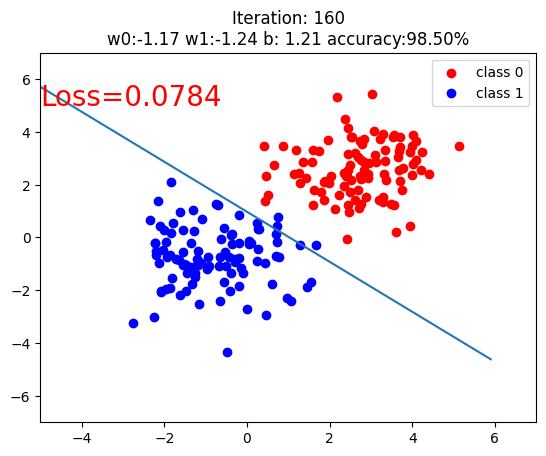

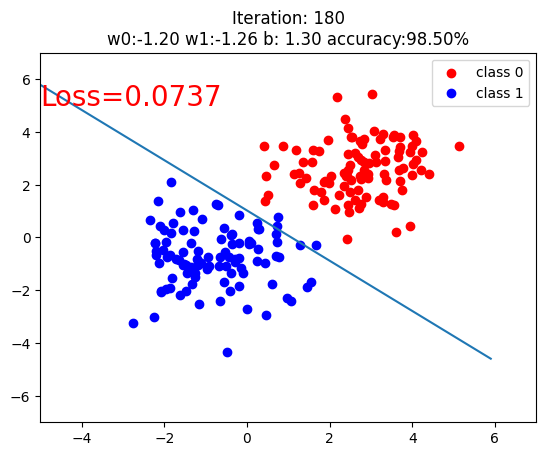

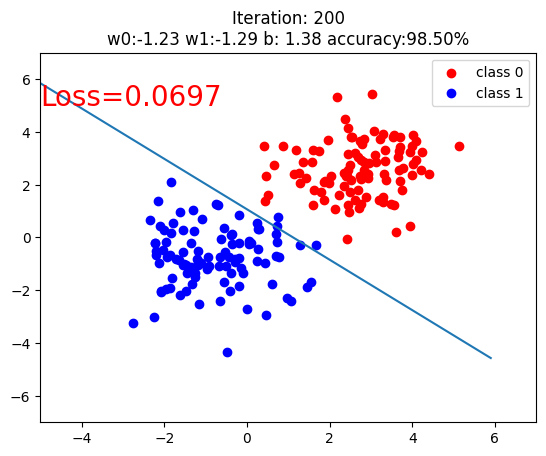

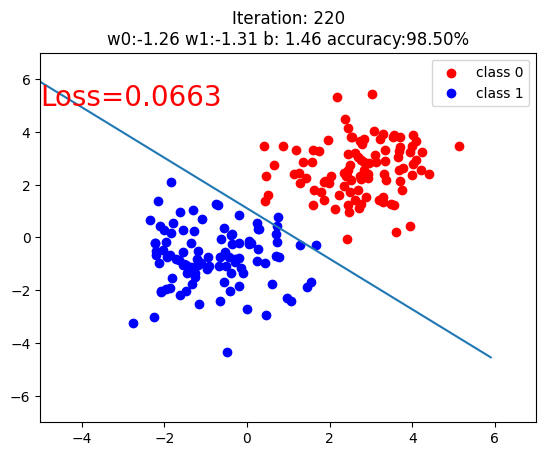

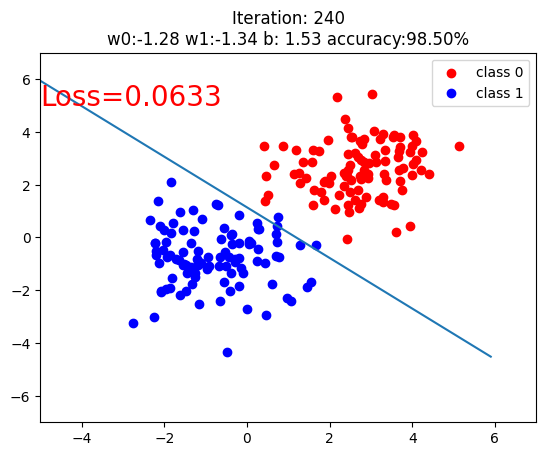

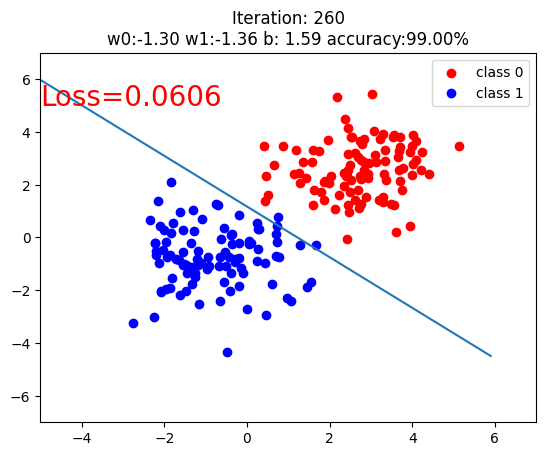

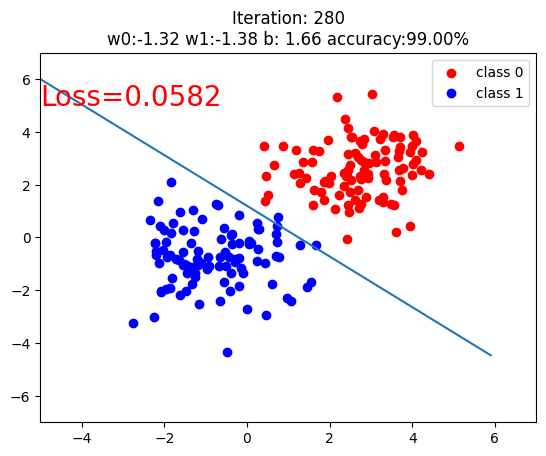

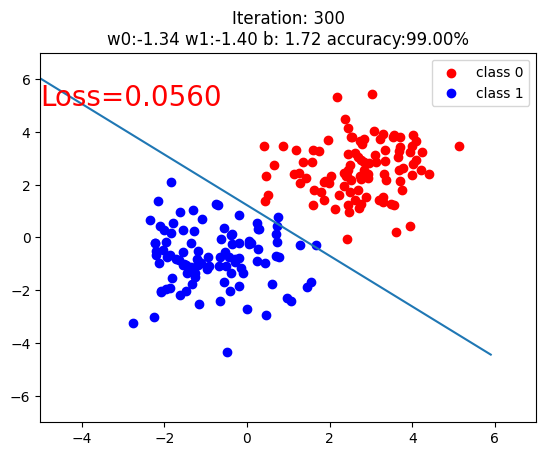

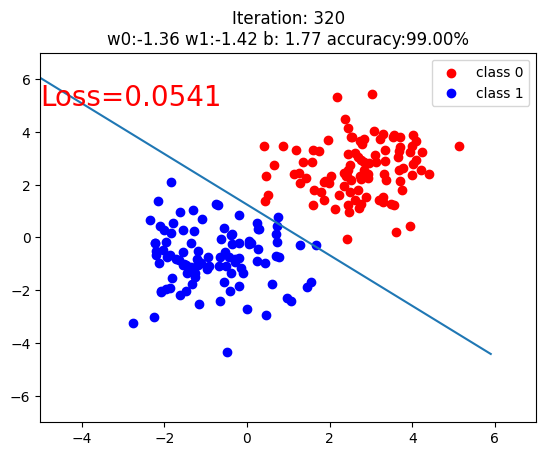

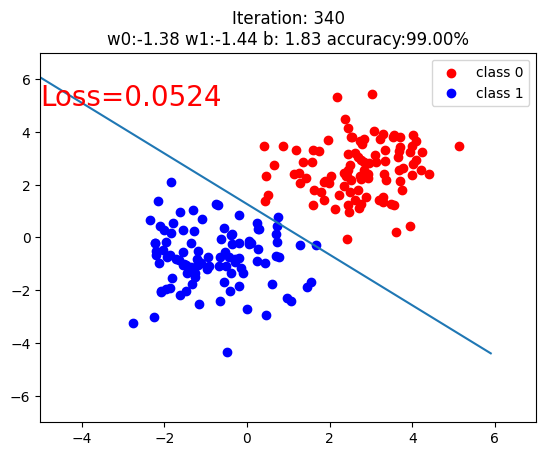

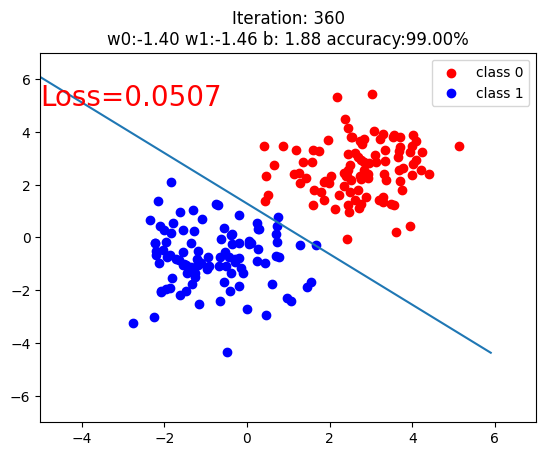

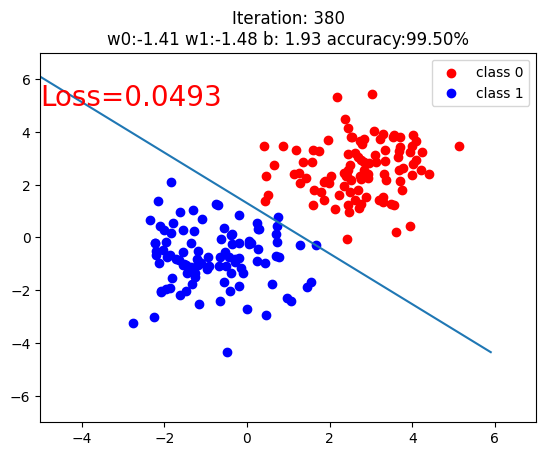

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(10)


# ============================ step 1/5 生成数据 ============================
sample_nums = 100 #指定了每个类别生成的数据点数量，即样本数量。
mean_value = 1.7 #定义了数据生成的均值。
bias = 1 

#这是分类问题 所以需要生成两个类别的数据

n_data = torch.ones(sample_nums, 2) #创建一个形状为 (sample_nums, 2) 的张量，所有元素初始值为1。
x0 = torch.normal(mean_value * n_data, 1) + bias      # 类别0 数据 shape=(100, 2) 标准差为1，生成了2个特征的数据
y0 = torch.zeros(sample_nums)                         # 类别0 标签 shape=(100, 1)
x1 = torch.normal(-mean_value * n_data, 1) + bias     # 类别1 数据 shape=(100, 2) 100个样本，每个样本有2个特征
y1 = torch.ones(sample_nums)                          # 类别1 标签 shape=(100, 1)
train_x = torch.cat((x0, x1), 0) #沿着0维（行轴，增加行数）来进行拼接，得到一个形状为 (200, 2) 的张量。
train_y = torch.cat((y0, y1), 0)


# ============================ step 2/5 选择模型 ============================
class LR(nn.Module): # 继承类 nn.Module，自动获得了 nn.Module 中的所有公共（非私有）属性和方法
    def __init__(self):
        super(LR, self).__init__()
        self.features = nn.Linear(2, 1) # 创建了一个线性层（Linear layer），它接收维度为2的输入（对应样本的两个特征），输出维度为1的向量。
        self.sigmoid = nn.Sigmoid() # 将线性层输出的连续值压缩到 (0, 1) 区间内，生成可用于概率解释的输出

    def forward(self, x):
        x = self.features(x)
        x = self.sigmoid(x)
        return x


lr_net = LR()   # 实例化逻辑回归模型


# ============================ step 3/5 选择损失函数 ============================
loss_fn = nn.BCELoss() # 二分类交叉熵损失函数

# ============================ step 4/5 选择优化器   ============================
lr = 0.01  # 学习率
optimizer = torch.optim.SGD(lr_net.parameters(), lr=lr, momentum=0.9)

# ============================ step 5/5 模型训练 ============================
for iteration in range(1000):

    # 前向传播
    y_pred = lr_net(train_x)

    # 计算 loss
    loss = loss_fn(y_pred.squeeze(), train_y)

    # 反向传播
    loss.backward()

    # 更新参数
    optimizer.step()

    # 清空梯度
    optimizer.zero_grad()

    # 绘图
    if iteration % 20 == 0:

        mask = y_pred.ge(0.5).float().squeeze()  # 以0.5为阈值进行分类
        correct = (mask == train_y).sum()  # 计算正确预测的样本个数
        acc = correct.item() / train_y.size(0)  # 计算分类准确率

        plt.scatter(x0.data.numpy()[:, 0], x0.data.numpy()[:, 1], c='r', label='class 0')
        plt.scatter(x1.data.numpy()[:, 0], x1.data.numpy()[:, 1], c='b', label='class 1')

        w0, w1 = lr_net.features.weight[0]
        w0, w1 = float(w0.item()), float(w1.item())
        plot_b = float(lr_net.features.bias[0].item())
        plot_x = np.arange(-6, 6, 0.1)
        plot_y = (-w0 * plot_x - plot_b) / w1

        plt.xlim(-5, 7)
        plt.ylim(-7, 7)
        plt.plot(plot_x, plot_y)

        plt.text(-5, 5, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color': 'red'}) #在图中添加文本，在（-5，5）的位置添加文本，文本内容为 Loss=loss.data.numpy()，字体大小为20，颜色为红色。
        plt.title("Iteration: {}\nw0:{:.2f} w1:{:.2f} b: {:.2f} accuracy:{:.2%}".format(iteration, w0, w1, plot_b, acc))
        plt.legend()

        plt.show()
        plt.pause(0.5)

        if acc > 0.99:
            break
